In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@feature_robust # for specific branch

import numpy as np
import matplotlib.pyplot as plt

## Set up test

In [15]:
our_function = lambda x:  (-0.3*x**4 -3*x**3 +0.6*x**2 +2.4*x - 0.5)
#our_function = lambda x:  1.8*x

In [28]:
N = 50 # number of training points (note, some will be removed below)
n = 4 # degree of polynomial
state = 15

noise_var = 0.1
x = np.sort(np.random.RandomState(state).uniform(-1,1,N))
y = our_function(x) + np.random.RandomState(state).normal(0,noise_var,size=N).T

pos = ((x>0)*(x<0.3)).nonzero()[0]
x = np.delete(x,pos)[:,None].squeeze()
y = np.delete(y,pos)[:,None].squeeze() 

# outliers!
#nout = 2
#index = np.random.RandomState(state).choice(len(y),nout,replace=False)
#y[index] += np.random.uniform(-1,1,nout,random_state=42)*4
#y[index[0]] += 2.8
#y[index[1]] -= 2.8
randrange = range(10,17)
y[randrange] = y[randrange]+np.random.RandomState(1).normal(0,4**2,len(randrange))

N = len(x)

dimensions = 1
if N < n: quit('N must exceed n')
    
x = x.reshape(-1,1)
xtest = np.linspace(-1,1,100).reshape(-1,1)
ytest = our_function(xtest)

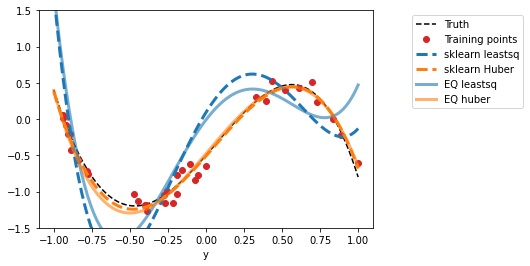

In [34]:
plt.plot(xtest,ytest,'k--',label='Truth')
plt.plot(x,y,'oC3',label='Training points')

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(n), LinearRegression())
model.fit(x,y)
ypred = model.predict(xtest)
plt.plot(xtest,ypred,'C0--',label='sklearn leastsq',lw=3)

model = make_pipeline(PolynomialFeatures(n), HuberRegressor(epsilon=1.35,alpha=0))
model.fit(x,y)
ypred = model.predict(xtest)
plt.plot(xtest,ypred,'C1--',label='sklearn Huber',lw=3)

#model = make_pipeline(PolynomialFeatures(n), RANSACRegressor())
#model.fit(x,y)
#ypred = model.predict(xtest)
#plt.plot(xtest,ypred,'C2--',label='sklearn RANSAC',alpha=0.6,lw=3)

from equadratures import *
param = Parameter(distribution='uniform', lower=-1, upper=1, order=n)
basis = Basis('univariate')
poly = Poly(parameters=param, basis=basis, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C0-',label='EQ leastsq',lw=3,alpha=0.6)

poly = Poly(parameters=param, basis=basis, method='huber', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)},
           solver_args={'param1':0.1})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C1-',label='EQ huber',lw=3,alpha=0.6)

plt.ylim([-1.5,1.5])
plt.xlabel('x')
plt.xlabel('y')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

Huber regression with M=0.04.
Solving using cvxpy with OSQP solver
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 134, constraints m = 129
          nnz(P) + nnz(A) = 473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -5.5039e+01   1.60e+01   2.26e+01   1.00e-01   2.12e-04s
 125   8.3705e-01   1.19e-05   5.37e-09  

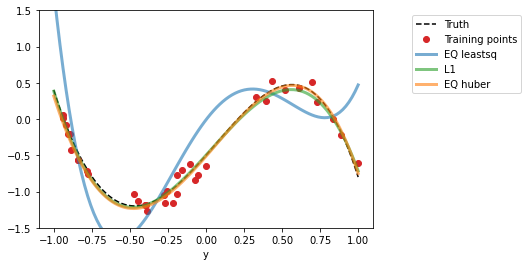

In [18]:
plt.plot(xtest,ytest,'k--',label='Truth')
plt.plot(x,y,'oC3',label='Training points')

param = Parameter(distribution='uniform', lower=-1, upper=1, order=n)
basis = Basis('univariate')
poly = Poly(parameters=param, basis=basis, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C0-',label='EQ leastsq',lw=3,alpha=0.6)

poly = Poly(parameters=param, basis=basis, method='least-absolute-residual', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C2-',label='L1',lw=3,alpha=0.6)

poly = Poly(parameters=param, basis=basis, method='huber', \
              sampling_args= {'mesh': 'user-defined', 'sample-points':x.reshape(-1,1), 'sample-outputs': y.reshape(-1,1)},
           solver_args={'param1':0.2**2,'verbose':True})
poly.set_model()
ypred = poly.get_polyfit(xtest.reshape(-1,1))
plt.plot(xtest,ypred,'C1-',label='EQ huber',lw=3,alpha=0.6)

plt.ylim([-1.5,1.5])
plt.xlabel('x')
plt.xlabel('y')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()